# Performance Prediction With Confidence Interval

In [238]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/data/home/admin/dss-data-dir/code-envs/python/drift_dac_exp/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'test', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [239]:
import pandas as pd
import pickle
import os
from scipy import stats

In [240]:
def sigma(p, n):
    return np.sqrt(p*(1-p)/n)

Load data

In [241]:
fld = "./video_games_pp"

In [242]:
with open(os.path.join(fld, 'all_models_0.pkl'), 'rb') as f:
    all_models = pickle.load(f)

In [243]:
data_fld = "./video_games"

In [244]:
with open(os.path.join(data_fld, 'data_0.pkl'), 'rb') as f:
    train, test, test_unseen, test_natural, ref_task, _ = pickle.load(f)

In [245]:
with open(os.path.join(data_fld, 'shifts_0.pkl'), 'rb') as f:
    list_of_drift_types, filtered_list_of_train_shifts, filtered_list_of_test_shifts, filtered_list_of_unseen_shifts = pickle.load(
        f)

In [246]:
# filter away subsample shift
perturbation_shifts_ids = [i for i, sh in enumerate(filtered_list_of_unseen_shifts) if
                           not any([sh_type in sh for sh_type in ('subsample', 'ko_shift')])]
subpop_shifts_ids = [i for i, sh in enumerate(filtered_list_of_unseen_shifts) if
                     any([sh_type in sh for sh_type in ('subsample', 'ko_shift')])]
no_shifts_ids = [i for i, sh in enumerate(filtered_list_of_test_shifts) if 'no_shift' in sh]
shifts_ids = [i for i, sh in enumerate(filtered_list_of_test_shifts) if not ('no_shift' in sh)]

In [247]:
all_models.keys()

dict_keys(['Dummy', 'ExpertRF', 'ExpertRF (amazon)', 'ExpertRF (naver)', 'MultiDomainClassifier', 'ErrorPredictorRF', 'ErrorPredictorRF_no_shift', 'ErrorPredictorKNN', 'ErrorPredictorGradBoost', 'DNN', 'DNN+Expert', 'ATC', 'MetaErrorPred', 'LODOErrorPredictor (oracle)', 'TargetDummy (oracle)', 'TargetErrorPredictor (oracle)'])

Gather all predictions from the Error Predictor trained on synthetic shifts

In [248]:
p_pred = all_models['ErrorPredictorRF']['test_no_shift']
p_pred = np.concatenate((p_pred, all_models['ErrorPredictorRF']['test']))
p_pred = np.concatenate((p_pred, all_models['ErrorPredictorRF']['test_unseen']))
p_pred = np.concatenate((p_pred, all_models['ErrorPredictorRF']['test_unseen_subpop']))
p_pred = np.concatenate((p_pred, all_models['ErrorPredictorRF']['test_natural']))

In [249]:
p_true = test.drops[no_shifts_ids]
p_true = np.concatenate((p_true, test.drops[shifts_ids]))
p_true = np.concatenate((p_true, test_unseen.drops[perturbation_shifts_ids]))
p_true = np.concatenate((p_true, test_unseen.drops[subpop_shifts_ids]))
p_true = np.concatenate((p_true, test_natural.drops))

In [250]:
n = test.datasets[0].shape[0]
n

475

## Estimate confidence intervals around predictions

In [257]:
alpha = 0.05
ci = stats.norm.ppf(1 - alpha / 2) * sigma(p_pred + ref_task.ref_accuracy, n)

In [258]:
ci_true = stats.norm.ppf(1 - alpha / 2) * sigma(p_true + ref_task.ref_accuracy, n)

In [261]:
# Mean Prediction Interval Width (MPIW)
MPIW = np.mean(2*ci)
MPIW

0.07688889076290024

In [262]:
# Prediction Interval Coverage Probability (PICP)
PICP = np.mean((p_pred-ci < p_true).astype(int) * (p_true < p_pred + ci).astype(int))
PICP

0.8390070921985816

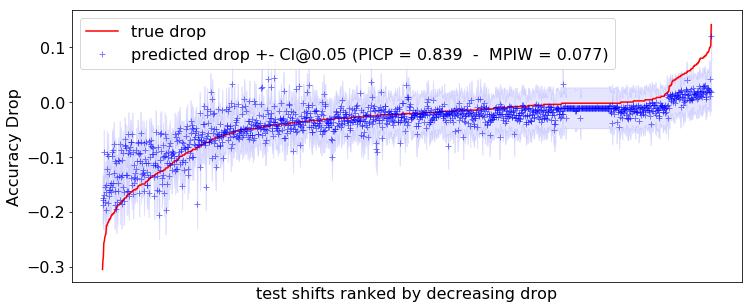

In [267]:
plt.rcParams.update({'font.size': 16})
out_fld = dataiku.Folder("video_games_data_viz").get_path()

plt.figure(figsize=(12, 5))
sorted_idx = np.argsort(p_true)
x = np.arange(0, len(sorted_idx))
plt.plot(x, p_true[sorted_idx], color='r', label='true drop');
#plt.fill_between(x, p_true[sorted_idx]-ci_true[sorted_idx], p_true[sorted_idx]+ci_true[sorted_idx], color='r', alpha=0.1)
plt.plot(x, p_pred[sorted_idx], color='b', label='predicted drop +- CI@%.2f (PICP = %.3f  -  MPIW = %.3f)'%(alpha, PICP, MPIW), marker='+', linewidth=0, alpha=0.5);
plt.fill_between(x, p_pred[sorted_idx]-ci[sorted_idx], p_pred[sorted_idx]+ci[sorted_idx], color='b', alpha=0.1)
plt.xticks([]);
plt.ylabel('Accuracy Drop');
#plt.title('PICP = %.3f  -  MPIW = %.3f' % (PICP, MPIW))
plt.xlabel('test shifts ranked by decreasing drop')
plt.legend();
plt.savefig(os.path.join(out_fld, 'uncertainty.png'), bbox_inches='tight')